In [1]:
import numpy as np
import matplotlib.pyplot as plt
import linecache
import math
import tensorflow as tf
from tensorflow.python.framework import ops
import pickle

# initialize mode params
num_mode=3
ny=161
nz=23
y=np.zeros((ny,1))
z=np.zeros((nz,1))
data1=np.zeros((ny,nz))
data2=np.zeros((ny,nz))
mode_data=[['' for i in range(3)] for j in range(1)]

# get mode1-3 E and H data
j=0
for i in range(3+1,3+1+ny):
    y[j,:]=linecache.getline(r'C:\Users\Ang Liu\Desktop\Mode_data\mode1_ey.txt', i).split()
    j+=1

j=0
for i in range(3+ny+2+1,3+ny+2+1+nz):
    z[j,:]=linecache.getline(r'C:\Users\Ang Liu\Desktop\Mode_data\mode1_ey.txt', i).split()
    j+=1

for k in range(num_mode):
    j=0
    for i in range(3+ny+2+nz+2+1,3+ny+2+nz+2+1+ny):
        data1[j,:]=linecache.getline(r'C:\Users\Ang Liu\Desktop\Mode_data\mode'+str(k+1)+'_ey.txt', i).split()
        j+=1  
    mode_data[0][k]=np.copy(data1.T)

# Normlize integral{|E|^2*dydz} to 1
dy=(y[-1,0]-y[0,0])/(y.shape[0]-1)
dz=(z[-1,0]-z[0,0])/(z.shape[0]-1)
norm_mode=np.zeros((1,num_mode))
for i in range(num_mode):
    norm_mode[0,i]=np.sum(mode_data[0][i]**2*dy*dz)
    mode_data[0][i]/=np.sqrt(norm_mode[0,i])

# show three Ey modes
# generate 2d grids for y and z
yy,zz=np.meshgrid(y,z)
plt.figure()
for i in range(num_mode):
    plt.subplot(num_mode, 1, i+1)
    plt.title('mode{}_ey'.format(i+1))
    plt.pcolormesh(yy,zz,mode_data[0][i])
    plt.xlabel("Y direction/micron")
    plt.ylabel("Z direction/micron")
    plt.ylim(-0.11, 0.33)
    plt.gca().set_aspect('equal', adjustable='box')
plt.tight_layout()
plt.show()

# Synthesis data set

m_base=300

if True:
    m_all=m_base # number of all the samples

    # pert=0.05 # perturbation of intensity after field's superposition

    np.random.seed(0) # random seed(0)
    rd1=np.random.rand(3,m_base)
    np.random.seed(1) # random seed(1)
    rd2=np.random.rand(3,m_base)

    mode_comp=np.zeros((num_mode,m_all),dtype=complex)
    mode_comp[:,:m_base]=rd1*np.exp(1j*rd2*2*np.pi)
else:
    with open('training_data_add_1_102417.data', 'rb') as f:
        training_data_add_1 = pickle.load(f)
    with open('training_data_add_2_102417.data', 'rb') as f:
        training_data_add_2 = pickle.load(f)

    m_all=m_base+len(training_data_add_1)+len(training_data_add_2) # number of all the samples

    # pert=0.05 # perturbation of intensity after field's superposition

    np.random.seed(0) # random seed(0)
    rd1=np.random.rand(3,m_base)
    np.random.seed(1) # random seed(1)
    rd2=np.random.rand(3,m_base)

    mode_comp=np.zeros((num_mode,m_all),dtype=complex)
    mode_comp[:,:m_base]=rd1*np.exp(1j*rd2*2*np.pi)
    mode_comp[:,m_base:m_base+len(training_data_add_1)]=np.array(training_data_add_1).T
    mode_comp[:,m_base+len(training_data_add_1):m_base+len(training_data_add_1)+len(training_data_add_2)]=\
                                                                                    np.array(training_data_add_2).T

field_sp=[[0+1j for i in range(m_all)] for j in range(1)] # [[Ey(0),...,Ey(m_all-1)]]
mode_comp_label=np.zeros((num_mode,m_all))
for i in range(m_all):
    for j in range(num_mode):
        field_sp[0][i]+=mode_comp[j,i]*mode_data[0][j]
mode_comp_label=np.abs(mode_comp)**2/np.sum(np.abs(mode_comp)**2,axis=0)

mode_comp_label[:,0]

# view specified sample
index=132
plt.figure(num=None, figsize=(8,8), dpi=80, facecolor='w', edgecolor='k')
plt.title('index_{}_|ey|'.format(index))
plt.pcolormesh(yy,zz,np.abs(field_sp[0][index])/np.max(np.abs(field_sp[0][index])))
plt.xlabel("Y direction/micron")
plt.ylabel("Z direction/micron")
plt.ylim(-0.11, 0.33)
plt.gca().set_aspect('equal', adjustable='box')
plt.colorbar(orientation='horizontal')
plt.show()

# get farfield diffraction pattern
sp_y=y.shape[0] # sampling points along y
sp_z=z.shape[0] # sampling points along z
ff_data=[]
for i in range(m_all):
    ff_data.append(np.fft.fftshift(np.fft.fft2(field_sp[0][i]))/sp_y/sp_z)

ff_i_data=['' for i in range(m_all)]
for i in range(m_all):
    ff_i_data[i]=np.abs(ff_data[i])**2

# view specified farfield pattern
sl_y=dy # sampling length(unit) along y
sl_z=dz # sampling length(unit) along z
sf_y=1/dy # sampling frequency along y
sf_z=1/dz # sampling frequency along z
f_y=np.fft.fftshift(np.fft.fftfreq(sp_y,sl_y))
f_z=np.fft.fftshift(np.fft.fftfreq(sp_z,sl_z))
index=132
plt.figure(num=None, figsize=(5,5), dpi=80, facecolor='w', edgecolor='k')
plt.pcolormesh(f_y,f_z,10*np.log10(ff_i_data[index]/np.max(ff_i_data[index])))
plt.title('Far field intensity distribution/dB')
plt.xlabel('far field y/a.u.')
plt.ylabel('far field z/a.u.')
plt.gca().set_aspect('equal', adjustable='box')
plt.colorbar()
plt.show()

ff_i_data[index].max()

temp_index=np.random.randint(m_all)
ff_i_data_eff_index_0,ff_i_data_eff_index_1=np.nonzero((ff_i_data[temp_index]/np.max(ff_i_data[temp_index]))>=1e-3)
print(ff_i_data_eff_index_0)
print(np.min(ff_i_data_eff_index_0),np.max(ff_i_data_eff_index_0))
print(ff_i_data_eff_index_1)
print(np.min(ff_i_data_eff_index_1),np.max(ff_i_data_eff_index_1))

ff_i_data_eff=['' for i in range(m_all)]
for i in range(m_all):
    ff_i_data_eff[i]=ff_i_data[i][9:12,70:91]

# view specified farfield pattern
sl_y=dy # sampling length(unit) along y
sl_z=dz # sampling length(unit) along z
sf_y=1/dy # sampling frequency along y
sf_z=1/dz # sampling frequency along z
f_y=np.fft.fftshift(np.fft.fftfreq(84-77,sl_y))
f_z=np.fft.fftshift(np.fft.fftfreq(13-10,sl_z))
index=132
plt.figure(num=None, figsize=(5,5), dpi=80, facecolor='w', edgecolor='k')
plt.imshow(10*np.log10(ff_i_data_eff[index]/np.max(ff_i_data_eff[index])))
plt.title('Far field intensity distribution/dB')
plt.xlabel('far field y/a.u.')
plt.ylabel('far field z/a.u.')
plt.gca().set_aspect('equal', adjustable='box')
plt.colorbar()
plt.show()

# converting 2D intensity to 1D features and shuffling
ff_i_data_eff=np.array(ff_i_data_eff)
ff_i_data_eff=ff_i_data_eff.reshape((300,-1)).T
np.random.seed(1000)
permutation = list(np.random.permutation(m_all))
ff_i_data_eff_shuffled=ff_i_data_eff[:,permutation]
mode_comp_label_shuffled=mode_comp_label[:,permutation]

# converting to logarithmic data
X_train=-np.log10(ff_i_data_eff_shuffled[:,:200])
X_test=-np.log10(ff_i_data_eff_shuffled[:,200:300])
Y_train=mode_comp_label_shuffled[:,:200]
Y_test=mode_comp_label_shuffled[:,200:300]

# normalizing features
mu_x_train=np.mean(X_train,axis=1,keepdims=True)
var_x_train=np.var(X_train,axis=1,keepdims=True)+1e-12
X_train=(X_train-mu_x_train)/np.sqrt(var_x_train)
X_test=(X_test-mu_x_train)/np.sqrt(var_x_train)

font_suptitle = {'family' : 'Times New Roman',
                 'weight' : 'bold',
                 'size'   : 18}
font_subtitle = {'family' : 'Times New Roman',
                 'weight' : 'bold',
                 'size'   : 15}
font_label = {'family' : 'Times New Roman',
              'weight' : 'bold',
              'size'   : 15}
font_tick = {'family' : 'Times New Roman',
             'weight' : 'semibold',
             'size'   : 8}

plt.figure(num=None, figsize=(8/1.5,6/1.5), dpi=80, facecolor='w', edgecolor='k')
plt.plot(range(X_train[:,index].shape[0]),X_train[:,index],'o-')
plt.title('Inspect X_train{{{}}}'.format(index), **font_suptitle,y=1.05)
plt.xlabel('Feature index', **font_label)
plt.ylabel('Feature value', **font_label)
plt.xticks(list(range(X_train[:,index].shape[0])),[str(i) for i in range(1,X_train[:,index].shape[0]+1)],
                                                                               **font_tick,rotation=-90)
plt.yticks(**font_tick)
plt.show()

In [20]:
def create_placeholders(n_x, n_y):
    X = tf.placeholder(tf.float32,[n_x,None])
    Y = tf.placeholder(tf.float32,[n_y,None])
    return X, Y

In [21]:
def initialize_parameters(parameters=None):
    if parameters==None:
        tf.set_random_seed(2)      
        W1 = tf.get_variable("W1", [25,63], initializer = tf.contrib.layers.xavier_initializer(seed = 3))
        b1 = tf.get_variable("b1", [25,1], initializer = tf.zeros_initializer())
        W2 = tf.get_variable("W2", [12,25], initializer = tf.contrib.layers.xavier_initializer(seed = 4))
        b2 = tf.get_variable("b2", [12,1], initializer = tf.zeros_initializer())
        W3 = tf.get_variable("W3", [3,12], initializer = tf.contrib.layers.xavier_initializer(seed = 5))
        b3 = tf.get_variable("b3", [3,1], initializer = tf.zeros_initializer())
    else:
        W1 = tf.get_variable("W1",  initializer = tf.constant(parameters['W1']))
        b1 = tf.get_variable("b1",  initializer = tf.constant(parameters['b1']))
        W2 = tf.get_variable("W2",  initializer = tf.constant(parameters['W2']))
        b2 = tf.get_variable("b2",  initializer = tf.constant(parameters['b2']))
        W3 = tf.get_variable("W3",  initializer = tf.constant(parameters['W3']))
        b3 = tf.get_variable("b3",  initializer = tf.constant(parameters['b3']))
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3}
    
    return parameters

In [22]:
def forward_propagation(X, parameters):   
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    
    Z1 = tf.matmul(W1,X) + b1                                              # Z1 = np.dot(W1, X) + b1
    A1 = tf.nn.tanh(Z1)                                              # A1 = tanh(Z1)
    Z2 = tf.matmul(W2,A1) + b2                                              # Z2 = np.dot(W2, a1) + b2
    A2 = tf.nn.tanh(Z2)                                              # A2 = tanh(Z2)
    Z3 = tf.matmul(W3,A2) + b3                                              # Z3 = np.dot(W3,Z2) + b3
   
    return Z3

In [23]:
def compute_cost1(Z3, Y):
    
    # to fit the tensorflow requirement for tf.nn.softmax_cross_entropy_with_logits(...,...)
    Z3 = tf.transpose(Z3)
    Y = tf.transpose(Y)
    A3 = tf.nn.softmax(Z3)
    cost = tf.reduce_mean(tf.reduce_sum(tf.abs(Y-A3),axis=1))
    
    return cost

In [24]:
def compute_cost2(Z3, Y):
    
    # to fit the tensorflow requirement for tf.nn.softmax_cross_entropy_with_logits(...,...)
    Z3 = tf.transpose(Z3)
    Y = tf.transpose(Y)
    A3 = tf.nn.softmax(Z3)
    cost = tf.reduce_mean(tf.reduce_sum((Y-A3)**2,axis=1))
    
    return tf.transpose(A3),cost

In [25]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (input size, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    mini_batch_size - size of the mini-batches, integer
    seed -- this is only for the purpose of grading, so that you're "random minibatches are the same as ours.
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    m = X.shape[1]                  # number of training examples
    mini_batches = []
    np.random.seed(seed)
    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((Y.shape[0],m))

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [26]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.0001,
          num_epochs = 1500, minibatch_size = 32, parameters=None, lambd=0, print_cost = True):
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    seed = 6                                          # to keep consistent results
    (n_x, m) = X_train.shape                          # (n_x: input size, m : number of examples in the train set)
    n_y = Y_train.shape[0]                            # n_y : output size
    costs = []                                        # To keep track of the cost
    
    # Create Placeholders of shape (n_x, n_y)
    X, Y = create_placeholders(n_x, n_y)

    # Initialize parameters
    parameters = initialize_parameters(parameters)
    W1 = parameters["W1"]
    W2 = parameters["W2"]
    W3 = parameters["W3"]
    regularizer = tf.nn.l2_loss(W1)+tf.nn.l2_loss(W2)+tf.nn.l2_loss(W3)
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    Z3 = forward_propagation(X, parameters)
    
    # Cost function: Add cost function to tensorflow graph
    # cost1 = compute_cost1(Z3, Y) # L1 norm
    _,cost2 = compute_cost2(Z3, Y) # L2 norm
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer.
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost2 + lambd * regularizer)
    
    # Initialize all the variables
    init = tf.global_variables_initializer()

    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            epoch_cost = 0.                       # Defines a cost related to an epoch
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                
                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the "optimizer" and the "cost", the feedict should contain a minibatch for (X,Y).
                _ , minibatch_cost = sess.run([optimizer, cost2], feed_dict={X: minibatch_X, Y: minibatch_Y})
                
                epoch_cost += minibatch_cost / num_minibatches

            # Print the cost every epoch
            if print_cost == True and epoch % 100 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)
                
        # plot the cost
        plt.plot(np.log10(np.squeeze(costs)))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # lets save the parameters in a variable
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")

        print ("Train mean square error:", sess.run(cost2,feed_dict={X: X_train, Y: Y_train}))
        print ("Test mean square error:", sess.run(cost2,feed_dict={X: X_test, Y: Y_test}))
        
        return parameters

Cost after epoch 0: 0.145665
Cost after epoch 100: 0.001955
Cost after epoch 200: 0.001113
Cost after epoch 300: 0.001180
Cost after epoch 400: 0.000964
Cost after epoch 500: 0.000732
Cost after epoch 600: 0.000868
Cost after epoch 700: 0.000757
Cost after epoch 800: 0.000738
Cost after epoch 900: 0.000992
Cost after epoch 1000: 0.000757
Cost after epoch 1100: 0.000523
Cost after epoch 1200: 0.000718
Cost after epoch 1300: 0.000577
Cost after epoch 1400: 0.000530
Cost after epoch 1500: 0.000619
Cost after epoch 1600: 0.000589
Cost after epoch 1700: 0.000515
Cost after epoch 1800: 0.000645
Cost after epoch 1900: 0.000463
Cost after epoch 2000: 0.000541
Cost after epoch 2100: 0.000633
Cost after epoch 2200: 0.000553
Cost after epoch 2300: 0.000729
Cost after epoch 2400: 0.000540
Cost after epoch 2500: 0.000677
Cost after epoch 2600: 0.000505
Cost after epoch 2700: 0.000603
Cost after epoch 2800: 0.000558
Cost after epoch 2900: 0.000527
Cost after epoch 3000: 0.001794
Cost after epoch 310

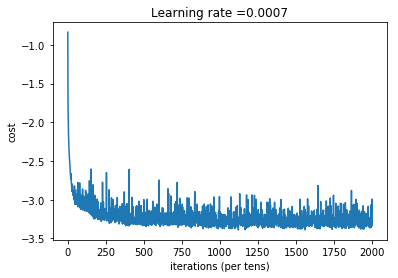

Parameters have been trained!
Train mean square error: 0.000429378
Test mean square error: 0.00129675


In [32]:
parameters = model(X_train, Y_train, X_test, Y_test, learning_rate = 7e-4,
          num_epochs = 10000, minibatch_size = 8, parameters=None, lambd=2e-4, print_cost = True)

learning rate_0: 0.0005237879216734268
lambd_0: 0.00013927540498051634
Cost after epoch 0: 0.155920
Cost after epoch 100: 0.002221
Cost after epoch 200: 0.001119
Cost after epoch 300: 0.001065
Cost after epoch 400: 0.000550
Cost after epoch 500: 0.000415
Cost after epoch 600: 0.000444
Cost after epoch 700: 0.000384
Cost after epoch 800: 0.000451
Cost after epoch 900: 0.000490
Cost after epoch 1000: 0.000650
Cost after epoch 1100: 0.000347
Cost after epoch 1200: 0.000479
Cost after epoch 1300: 0.000301
Cost after epoch 1400: 0.000386
Cost after epoch 1500: 0.000513
Cost after epoch 1600: 0.000340
Cost after epoch 1700: 0.000286
Cost after epoch 1800: 0.000421
Cost after epoch 1900: 0.000261
Cost after epoch 2000: 0.000278
Cost after epoch 2100: 0.000385
Cost after epoch 2200: 0.000286
Cost after epoch 2300: 0.000312
Cost after epoch 2400: 0.000328
Cost after epoch 2500: 0.000286
Cost after epoch 2600: 0.000241
Cost after epoch 2700: 0.000285
Cost after epoch 2800: 0.000389
Cost after ep

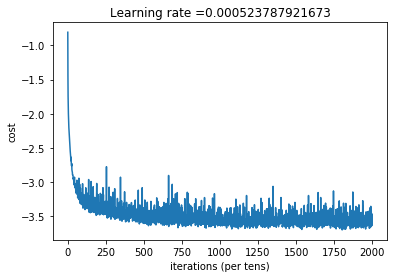

Parameters have been trained!
Train mean square error: 0.000210348
Test mean square error: 0.0011038
learning rate_1: 0.00013070261394587389
lambd_1: 0.00010008622768351319
Cost after epoch 0: 0.186177
Cost after epoch 100: 0.007555
Cost after epoch 200: 0.003507
Cost after epoch 300: 0.002017
Cost after epoch 400: 0.001309
Cost after epoch 500: 0.000942
Cost after epoch 600: 0.000715
Cost after epoch 700: 0.000568
Cost after epoch 800: 0.000455
Cost after epoch 900: 0.000402
Cost after epoch 1000: 0.000349
Cost after epoch 1100: 0.000313
Cost after epoch 1200: 0.000294
Cost after epoch 1300: 0.000281
Cost after epoch 1400: 0.000276
Cost after epoch 1500: 0.000244
Cost after epoch 1600: 0.000244
Cost after epoch 1700: 0.000238
Cost after epoch 1800: 0.000239
Cost after epoch 1900: 0.000221
Cost after epoch 2000: 0.000211
Cost after epoch 2100: 0.000251
Cost after epoch 2200: 0.000200
Cost after epoch 2300: 0.000226
Cost after epoch 2400: 0.000238
Cost after epoch 2500: 0.000212
Cost af

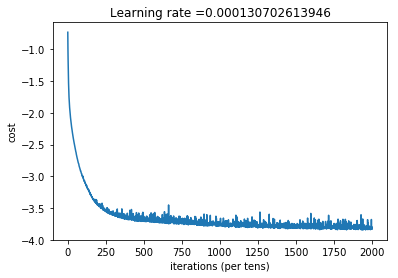

Parameters have been trained!
Train mean square error: 0.000138973
Test mean square error: 0.00437325
learning rate_2: 0.0001363851425044411
lambd_2: 0.00016191470759103571
Cost after epoch 0: 0.185655
Cost after epoch 100: 0.007291
Cost after epoch 200: 0.003377
Cost after epoch 300: 0.001944
Cost after epoch 400: 0.001279
Cost after epoch 500: 0.000950
Cost after epoch 600: 0.000752
Cost after epoch 700: 0.000646
Cost after epoch 800: 0.000561
Cost after epoch 900: 0.000516
Cost after epoch 1000: 0.000451
Cost after epoch 1100: 0.000407
Cost after epoch 1200: 0.000393
Cost after epoch 1300: 0.000370
Cost after epoch 1400: 0.000354
Cost after epoch 1500: 0.000337
Cost after epoch 1600: 0.000345
Cost after epoch 1700: 0.000338
Cost after epoch 1800: 0.000327
Cost after epoch 1900: 0.000324
Cost after epoch 2000: 0.000303
Cost after epoch 2100: 0.000351
Cost after epoch 2200: 0.000316
Cost after epoch 2300: 0.000310
Cost after epoch 2400: 0.000330
Cost after epoch 2500: 0.000287
Cost af

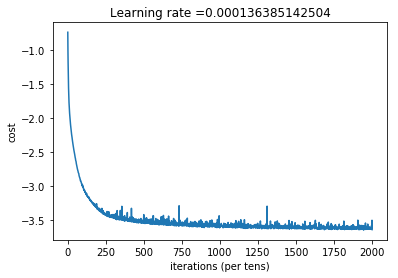

Parameters have been trained!
Train mean square error: 0.00022757
Test mean square error: 0.00302207
learning rate_3: 0.0001106448086091065
lambd_3: 0.00018373119512862712
Cost after epoch 0: 0.188034
Cost after epoch 100: 0.008709
Cost after epoch 200: 0.004132
Cost after epoch 300: 0.002442
Cost after epoch 400: 0.001612
Cost after epoch 500: 0.001191
Cost after epoch 600: 0.000927
Cost after epoch 700: 0.000780
Cost after epoch 800: 0.000684
Cost after epoch 900: 0.000648
Cost after epoch 1000: 0.000576
Cost after epoch 1100: 0.000527
Cost after epoch 1200: 0.000495
Cost after epoch 1300: 0.000453
Cost after epoch 1400: 0.000415
Cost after epoch 1500: 0.000398
Cost after epoch 1600: 0.000387
Cost after epoch 1700: 0.000397
Cost after epoch 1800: 0.000366
Cost after epoch 1900: 0.000358
Cost after epoch 2000: 0.000347
Cost after epoch 2100: 0.000384
Cost after epoch 2200: 0.000349
Cost after epoch 2300: 0.000342
Cost after epoch 2400: 0.000343
Cost after epoch 2500: 0.000319
Cost aft

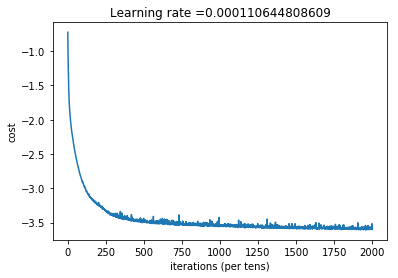

Parameters have been trained!
Train mean square error: 0.000247402
Test mean square error: 0.00325844
learning rate_4: 0.0003534744737897858
lambd_4: 0.00016810767046813402
Cost after epoch 0: 0.167653
Cost after epoch 100: 0.003107
Cost after epoch 200: 0.001309
Cost after epoch 300: 0.000940
Cost after epoch 400: 0.000702
Cost after epoch 500: 0.000506
Cost after epoch 600: 0.000527
Cost after epoch 700: 0.000414
Cost after epoch 800: 0.000391
Cost after epoch 900: 0.000516
Cost after epoch 1000: 0.000470
Cost after epoch 1100: 0.000408
Cost after epoch 1200: 0.000486
Cost after epoch 1300: 0.000344
Cost after epoch 1400: 0.000377
Cost after epoch 1500: 0.000504
Cost after epoch 1600: 0.000363
Cost after epoch 1700: 0.000338
Cost after epoch 1800: 0.000424
Cost after epoch 1900: 0.000314
Cost after epoch 2000: 0.000310
Cost after epoch 2100: 0.000458
Cost after epoch 2200: 0.000376
Cost after epoch 2300: 0.000363
Cost after epoch 2400: 0.000403
Cost after epoch 2500: 0.000358
Cost af

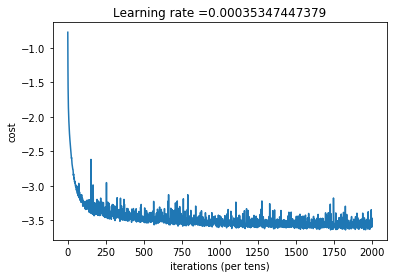

Parameters have been trained!
Train mean square error: 0.000237239
Test mean square error: 0.00124515
learning rate_5: 0.00014206797399357577
lambd_5: 0.0001157406031144643
Cost after epoch 0: 0.185138
Cost after epoch 100: 0.007041
Cost after epoch 200: 0.003236
Cost after epoch 300: 0.001847
Cost after epoch 400: 0.001205
Cost after epoch 500: 0.000875
Cost after epoch 600: 0.000674
Cost after epoch 700: 0.000550
Cost after epoch 800: 0.000442
Cost after epoch 900: 0.000399
Cost after epoch 1000: 0.000354
Cost after epoch 1100: 0.000321
Cost after epoch 1200: 0.000310
Cost after epoch 1300: 0.000295
Cost after epoch 1400: 0.000291
Cost after epoch 1500: 0.000260
Cost after epoch 1600: 0.000271
Cost after epoch 1700: 0.000259
Cost after epoch 1800: 0.000261
Cost after epoch 1900: 0.000243
Cost after epoch 2000: 0.000230
Cost after epoch 2100: 0.000262
Cost after epoch 2200: 0.000228
Cost after epoch 2300: 0.000252
Cost after epoch 2400: 0.000271
Cost after epoch 2500: 0.000234
Cost af

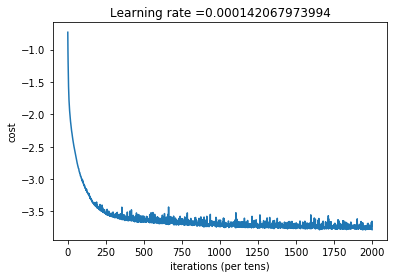

Parameters have been trained!
Train mean square error: 0.000162087
Test mean square error: 0.00372163
learning rate_6: 0.00015894297682262913
lambd_6: 0.00013785632803016494
Cost after epoch 0: 0.183614
Cost after epoch 100: 0.006404
Cost after epoch 200: 0.002902
Cost after epoch 300: 0.001643
Cost after epoch 400: 0.001098
Cost after epoch 500: 0.000815
Cost after epoch 600: 0.000641
Cost after epoch 700: 0.000541
Cost after epoch 800: 0.000439
Cost after epoch 900: 0.000417
Cost after epoch 1000: 0.000371
Cost after epoch 1100: 0.000340
Cost after epoch 1200: 0.000344
Cost after epoch 1300: 0.000318
Cost after epoch 1400: 0.000314
Cost after epoch 1500: 0.000289
Cost after epoch 1600: 0.000310
Cost after epoch 1700: 0.000293
Cost after epoch 1800: 0.000295
Cost after epoch 1900: 0.000277
Cost after epoch 2000: 0.000261
Cost after epoch 2100: 0.000288
Cost after epoch 2200: 0.000274
Cost after epoch 2300: 0.000290
Cost after epoch 2400: 0.000318
Cost after epoch 2500: 0.000266
Cost a

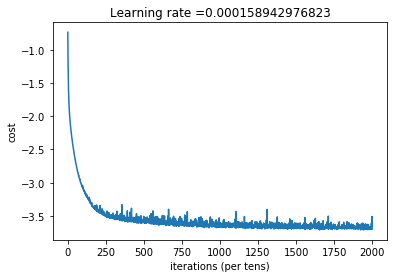

Parameters have been trained!
Train mean square error: 0.000199475
Test mean square error: 0.00289458
learning rate_7: 0.00010294899890735
lambd_7: 0.00019415268160543313
Cost after epoch 0: 0.188755
Cost after epoch 100: 0.009263
Cost after epoch 200: 0.004426
Cost after epoch 300: 0.002639
Cost after epoch 400: 0.001752
Cost after epoch 500: 0.001291
Cost after epoch 600: 0.001005
Cost after epoch 700: 0.000841
Cost after epoch 800: 0.000732
Cost after epoch 900: 0.000687
Cost after epoch 1000: 0.000615
Cost after epoch 1100: 0.000572
Cost after epoch 1200: 0.000544
Cost after epoch 1300: 0.000505
Cost after epoch 1400: 0.000462
Cost after epoch 1500: 0.000438
Cost after epoch 1600: 0.000418
Cost after epoch 1700: 0.000416
Cost after epoch 1800: 0.000389
Cost after epoch 1900: 0.000377
Cost after epoch 2000: 0.000370
Cost after epoch 2100: 0.000392
Cost after epoch 2200: 0.000367
Cost after epoch 2300: 0.000363
Cost after epoch 2400: 0.000358
Cost after epoch 2500: 0.000339
Cost afte

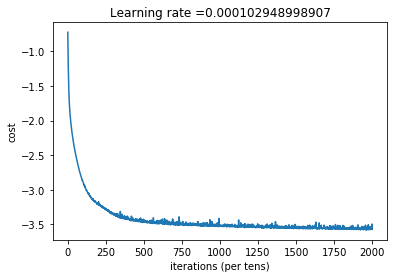

Parameters have been trained!
Train mean square error: 0.000260432
Test mean square error: 0.00310559
learning rate_8: 0.0002519016713338424
lambd_8: 0.0002401635521711969
Cost after epoch 0: 0.175627
Cost after epoch 100: 0.004297
Cost after epoch 200: 0.001857
Cost after epoch 300: 0.001110
Cost after epoch 400: 0.000895
Cost after epoch 500: 0.000697
Cost after epoch 600: 0.000675
Cost after epoch 700: 0.000613
Cost after epoch 800: 0.000582
Cost after epoch 900: 0.000597
Cost after epoch 1000: 0.000521
Cost after epoch 1100: 0.000505
Cost after epoch 1200: 0.000516
Cost after epoch 1300: 0.000479
Cost after epoch 1400: 0.000477
Cost after epoch 1500: 0.000497
Cost after epoch 1600: 0.000482
Cost after epoch 1700: 0.000483
Cost after epoch 1800: 0.000481
Cost after epoch 1900: 0.000461
Cost after epoch 2000: 0.000412
Cost after epoch 2100: 0.000525
Cost after epoch 2200: 0.000530
Cost after epoch 2300: 0.000443
Cost after epoch 2400: 0.000523
Cost after epoch 2500: 0.000447
Cost aft

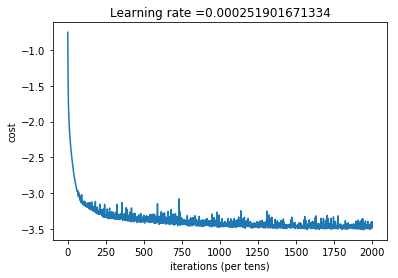

Parameters have been trained!
Train mean square error: 0.000309943
Test mean square error: 0.00129421
learning rate_9: 0.0001386627529762488
lambd_9: 0.0002513416391777296
Cost after epoch 0: 0.185448
Cost after epoch 100: 0.007196
Cost after epoch 200: 0.003345
Cost after epoch 300: 0.001941
Cost after epoch 400: 0.001304
Cost after epoch 500: 0.001008
Cost after epoch 600: 0.000827
Cost after epoch 700: 0.000747
Cost after epoch 800: 0.000696
Cost after epoch 900: 0.000696
Cost after epoch 1000: 0.000637
Cost after epoch 1100: 0.000627
Cost after epoch 1200: 0.000636
Cost after epoch 1300: 0.000595
Cost after epoch 1400: 0.000564
Cost after epoch 1500: 0.000536
Cost after epoch 1600: 0.000518
Cost after epoch 1700: 0.000520
Cost after epoch 1800: 0.000472
Cost after epoch 1900: 0.000469
Cost after epoch 2000: 0.000453
Cost after epoch 2100: 0.000494
Cost after epoch 2200: 0.000453
Cost after epoch 2300: 0.000450
Cost after epoch 2400: 0.000472
Cost after epoch 2500: 0.000430
Cost aft

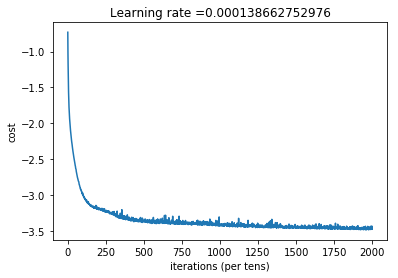

Parameters have been trained!
Train mean square error: 0.000329661
Test mean square error: 0.00153628


In [35]:
parameters_set=['' for i in range(10)]
np.random.seed(None)
lr_set=10**np.random.uniform(-4,-3,10)
lambd_set=10**np.random.uniform(-4,-3.5,10)
for i in range(len(lr_set)):
    print('learning rate_{}: {}'.format(i,lr_set[i]))
    print('lambd_{}: {}'.format(i,lambd_set[i]))
    parameters_set[i]=model(X_train, Y_train, X_test, Y_test, learning_rate = lr_set[i],
    num_epochs = 10000, minibatch_size = 8, parameters=None, lambd=lambd_set[i], print_cost = True)

In [36]:
def model_check(X_train, Y_train, X_test, Y_test, parameters = None, print_cost = True):
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    (n_x, m) = X_train.shape                          # (n_x: input size, m : number of examples in the train set)
    n_y = Y_train.shape[0]                            # n_y : output size
    
    # Create Placeholders of shape (n_x, n_y)
    X, Y = create_placeholders(n_x, n_y)

    # Initialize parameters
    parameters = initialize_parameters(parameters)
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    Z3 = forward_propagation(X, parameters)
    
    # Cost function: Add cost function to tensorflow graph
    # cost1 = compute_cost1(Z3, Y) # L1 norm
    A3,cost2 = compute_cost2(Z3, Y) # L2 norm
    
    # Initialize all the variables
    init = tf.global_variables_initializer()

    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        [parameters, A3_train, cost2_train]=sess.run([parameters, A3, cost2], feed_dict={X: X_train, Y: Y_train})
        [A3_test,cost2_test]=sess.run([A3, cost2], feed_dict={X: X_test, Y: Y_test})
    if print_cost==True:
        print("Train mean square error: {:.2e}.".format(cost2_train))
        print("Test mean square error: {:.2e}.".format(cost2_test))
        
        
        return parameters,A3_train,cost2_train,A3_test,cost2_test

In [37]:
np.random.seed(None)
index=np.squeeze(np.random.randint(100,size=(1,1)))
print("index_{}:".format(index))
print(A3_test.T[index,:])
print(Y_test.T[index,:])

index_94:


NameError: name 'A3_test' is not defined

In [38]:
A3_train=['' for i in range(10)]
cost_train=np.zeros((10,1))
A3_test=['' for i in range(10)]    
cost_test=np.zeros((10,1))
for i in range(len(lr_set)):
    [_,A3_train[i],cost_train[i],A3_test[i],cost_test[i]]=\
    model_check(X_train, Y_train, X_test, Y_test, parameters = parameters_set[i], print_cost = True)

Train mean square error: 2.10e-04.
Test mean square error: 1.10e-03.
Train mean square error: 1.39e-04.
Test mean square error: 4.37e-03.
Train mean square error: 2.28e-04.
Test mean square error: 3.02e-03.
Train mean square error: 2.47e-04.
Test mean square error: 3.26e-03.
Train mean square error: 2.37e-04.
Test mean square error: 1.25e-03.
Train mean square error: 1.62e-04.
Test mean square error: 3.72e-03.
Train mean square error: 1.99e-04.
Test mean square error: 2.89e-03.
Train mean square error: 2.60e-04.
Test mean square error: 3.11e-03.
Train mean square error: 3.10e-04.
Test mean square error: 1.29e-03.
Train mean square error: 3.30e-04.
Test mean square error: 1.54e-03.


In [45]:
min_tc_index=np.unravel_index(np.argmin(cost_test), (10,1)) # min test cost index
print(min_tc_index)

(0, 0)


In [46]:
cost_test[min_tc_index]

0.0011037988588213921

In [47]:
cost_train[min_tc_index]

0.0002103482693200931

In [42]:
# save hyprams minimizing cost_test
f = open('parameters_min_test_cost_1446_102717.data', 'wb')
pickle.dump([parameters_set[min_tc_index[0]],mu_x_train,var_x_train], f)
f.close()

In [43]:
# load (hyper)prams test
f = open('parameters_min_test_cost_1446_102717.data', 'rb')
[temp1,temp2,temp3]=pickle.load(f)
f.close()

In [44]:
print(temp2,temp3)

[[  6.22660901e+00]
 [  6.51942985e+00]
 [  6.14569837e+00]
 [  6.35043682e+00]
 [  6.16848283e+00]
 [  6.26504571e+00]
 [  6.69834985e+00]
 [  5.41882547e+00]
 [  4.80054222e+00]
 [  4.81263807e+00]
 [  4.73751202e+00]
 [  4.85215790e+00]
 [  4.82993614e+00]
 [  5.46784570e+00]
 [  6.71767065e+00]
 [  6.26491827e+00]
 [  6.18335012e+00]
 [  6.36436821e+00]
 [  6.17135673e+00]
 [  6.54287925e+00]
 [  6.24461280e+00]
 [  5.46956922e+00]
 [  4.90570422e+00]
 [  5.16646100e+00]
 [  4.76929855e+00]
 [  4.50837351e+00]
 [  4.36836138e+00]
 [  3.08446218e+00]
 [  2.33240527e+00]
 [  2.06183819e+00]
 [  2.08822088e+00]
 [  2.07720041e+00]
 [  2.09987692e+00]
 [  2.11687378e+00]
 [  2.37499044e+00]
 [  3.08584917e+00]
 [  4.33909247e+00]
 [  4.49785206e+00]
 [  4.78473039e+00]
 [  5.18127506e+00]
 [  4.92746991e+00]
 [  5.45169285e+00]
 [  4.89494203e+00]
 [  4.28671015e+00]
 [  4.68612079e+00]
 [  4.10943527e+00]
 [  3.95149409e+00]
 [  3.69981889e+00]
 [  2.43164446e+00]
 [  1.65978010e+00]


In [ ]:
lr_set[7]

In [ ]:
lambd_set[7]